# Final evaluation of model paths

In [70]:
cafe = "cafe"
pgpr = "pgpr"
models = [cafe, pgpr]
all_relations = ["created_by", "has_micro_genre", "has_genre", "in_album", "listened_to"]

dataset = "lfm"

In [2]:
from random import seed, randint, choice
from collections import defaultdict
import pickle
import numpy as np

### Some basic evaluation functions

In [3]:
def dcg_at_k(topk, k, method=1):
    topk = np.asfarray(topk)[:k]
    if topk.size:
        if method == 0:
            return topk[0] + np.sum(topk[1:] / np.log2(np.arange(2, topk.size + 1)))
        elif method == 1:
            return np.sum(topk / np.log2(np.arange(2, topk.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(topk, k, method=1):
    dcg_max = dcg_at_k(sorted(topk, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(topk, k, method) / dcg_max

def recall_at_k(topk, test_pids):
    return sum(topk) / len(test_pids)
    
def precision_at_k(topk, k):
    return sum(topk) / k

In [4]:
def path_len(path):
    len = 0
    for s in path:
        if type(s) != str:
            s = str(s)
        if s.isnumeric():
            len+=1
    return len

# Path Structure: user 5038 watched product 2430 watched user 1498 watched product 1788
def template(curr_model, path):
    if path[0] == "self_loop":
        path = path[1:]

    path_length = path_len(path)
    for i in range(1, len(path)):
        s = str(path[i])
        if s.isnumeric():
            if path[i-1] == 'user': continue
            if int(path[i]) not in entity2name[curr_model][path[i-1]]: continue
            path[i] = entity2name[curr_model][path[i-1]][int(path[i])]
    if path_length == 4:
        _, uid, rel_0, e_type_1, e_1, rel_1, e_type_2, e_2, rel_k, _, pid  = path
        return f"{pid} is recommend to you because you {rel_0} {e_1} also {rel_k} by {e_2}"
    elif path_len(path) == 3:
        _, uid, rel_0, e_type_1, e_1, rel_1, _, pid  = path
        return f"{pid} is recommend to you because is {r_k} with {e_1} that you previously {rel_0}"

In [5]:
from knowledge_graph_utils import entity2plain_text
entity2name = {}
entity2name["cafe"] = entity2plain_text(dataset, "cafe")
entity2name["pgpr"] = entity2plain_text(dataset, "pgpr")

### Load train and test labels for each model

In [6]:
train_labels = {}
test_labels = {}

In [7]:
model_name = "pgpr"
%cd models/PGPR
from pgpr_utils import load_labels

train_labels[model_name] = load_labels(dataset, 'train')
test_labels[model_name] = load_labels(dataset, 'test')
%cd ../..


/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR
/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src


In [8]:
model_name = "cafe"
%cd models/CAFE

from cafe_utils import load_labels

train_labels[model_name] = load_labels(dataset, 'train')
test_labels[model_name] = load_labels(dataset, 'test')
%cd ../..

/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/CAFE
/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src


In [9]:
def load_paths(model):
    with open(f"results/lfm/{model}/pred_paths.pkl", 'rb') as pred_paths_file:
        paths = pickle.load(pred_paths_file)
    pred_paths_file.close()
    
    pred_paths_map = defaultdict(dict)
    for record in paths:
        uid, pid, path_score, path_prob, path = record
        if pid not in pred_paths_map[uid]:
            pred_paths_map[uid][pid] = []
        pred_paths_map[uid][pid].append((float(path_score), float(path_prob), path))
    return pred_paths_map

In [10]:
def select_best_paths(pred_paths_map, model):
    best_pred_paths = {}
    for uid in pred_paths_map:
        if uid in train_labels[model]:
            train_pids = set(train_labels[model][uid])
        else:
            print("Invalid train_pids")
        best_pred_paths[uid] = []
        for pid in pred_paths_map[uid]:
            if pid in train_pids:
                continue
            # Get the path with highest probability
            sorted_path = sorted(pred_paths_map[uid][pid], key=lambda x: x[1], reverse=True)
            best_pred_paths[uid].append(sorted_path[0])
    return best_pred_paths

In [11]:
def paths_for_top_k(model, best_paths, k):
    users_topk = defaultdict(list)
    if model == "pgpr":
        for uid in range(len(best_paths.keys())):
            sorted_paths = sorted(best_paths[uid], key=lambda x: (x[0], x[1]), reverse=True)
            sorted_paths = [[path[0], path[1], path[-1].split(" ")] for path in sorted_paths]
            topk_products = [int(path[-1][-1]) for path in sorted_paths[:k]]
            topk_explanations = [path[-1] for path in sorted_paths[:k]]
            users_topk[uid] = list(zip(topk_products, topk_explanations))
    elif model == "cafe":
        for uid, pids in best_paths.items():
            user_paths = []
            for paths in pids.values():
                user_paths.extend(paths)
            sorted(user_paths, key=lambda x: x[0], reverse=True)
            users_topk[uid] = [(path[-1][-1], path[-1]) for path in user_paths[:k]]
    return users_topk

In [42]:
def metrics_for_top_k(user_topk, model):
    ndcgs = []
    recalls = []
    precisions = []
    for uid, rec_exp_tuples in user_topk.items():
        hits = []
        for rec_exp_tuple in rec_exp_tuples:
            recommended_pid = rec_exp_tuple[0]
            if recommended_pid in test_labels[model][uid]:
                hits.append(1)
            else:
                hits.append(0)
        while len(hits) < 10:
            hits.append(0)
        ndcg = ndcg_at_k(hits, k)
        precision = precision_at_k(hits, k)
        recall = recall_at_k(hits, test_labels[model][uid])
        ndcgs.append(ndcg)
        precisions.append(precision)
        recalls.append(recall)
    print(f"Overall NDGC: {np.mean(ndcgs)}, Precision: {np.mean(precisions)}, Recall: {np.mean(recalls)}")
    return float(np.mean(ndcgs)), float(np.mean(precisions)), float(np.mean(recalls))

## Evaluate basic path properties

In [13]:
model_name = "pgpr"

In [14]:
pred_paths_map_pgpr = load_paths(model_name)

In [15]:
n_users = len(pred_paths_map_pgpr.keys())
random_user = randint(0, n_users)
random_product = choice(list(pred_paths_map_pgpr[random_user].keys()))
print(pred_paths_map_pgpr[random_user][random_product])
print(len(pred_paths_map_pgpr[random_user]))

[(0.5060297686124058, 3.904561708623078e-06, 'self_loop user 5551 listened_to product 15306 listened_to user 977 listened_to product 32411')]
429


In [16]:
best_paths = select_best_paths(pred_paths_map_pgpr, model_name)

In [17]:
random_user = randint(0, n_users)
print(best_paths[random_user][:5])

[(0.49502465089876063, 0.006757840979844332, 'self_loop user 5794 listened_to product 142095 listened_to user 2843 listened_to product 173325'), (0.48263558932090306, 0.004139266442507505, 'self_loop user 5794 listened_to product 142095 listened_to user 4801 listened_to product 173105'), (0.5873933051240597, 0.008527599275112152, 'self_loop user 5794 listened_to product 25333 listened_to user 8819 listened_to product 169005'), (0.522749673737351, 0.010078049264848232, 'self_loop user 5794 listened_to product 25333 listened_to user 9142 listened_to product 170869'), (0.48994672081952945, 0.0028207667637616396, 'self_loop user 5794 listened_to product 142095 listened_to user 1972 listened_to product 173475')]


In [18]:
k = 10
topk_paths = {}
topk_paths[model_name] = paths_for_top_k(model_name, best_paths, k)

In [19]:
metrics_for_top_k(topk_paths[model_name], model_name)

Overall NDGC: 0.09202033030883408, Precision: 0.02277102062400846, Recall: 0.002607531456789202


(0.09202033030883408, 0.02277102062400846, 0.002607531456789202)

In [51]:
def count_relations(user_topk, model, relative = False):
    relation_counts = {}
    for user in user_topk:
        for i in range(len(user_topk[user])):
            relation_index = 6 if model == "pgpr" else 5
            relation = user_topk[user][i][1][relation_index]
            if relation == "rev_listened":
                relation = "listened_to"
            if relation not in relation_counts:
                relation_counts[relation] = 1
            else:
                relation_counts[relation] = relation_counts[relation] + 1
    
    if relative:
        total_relation_counts = 0
        for relation_name in relation_counts.keys():
            total_relation_counts = total_relation_counts + relation_counts[relation_name]
        for relation_name in relation_counts.keys():
            relation_counts[relation_name] = relation_counts[relation_name] * 100 / total_relation_counts
    return relation_counts

In [21]:
relation_counts = {}
relation_counts[model_name] = count_relations(topk_paths[model_name], model_name)

In [22]:
model_name = "cafe"

predicted_paths = load_paths(model_name)
topk_paths[model_name]  = paths_for_top_k(model_name, predicted_paths, k)
relation_counts[model_name] = count_relations(topk_paths[model_name], model_name)
metrics_for_top_k(topk_paths[model_name], model_name)


Overall NDGC: 0.07641083248013784, Precision: 0.01965097831835008, Recall: 0.003043877015559237


(0.07641083248013784, 0.01965097831835008, 0.003043877015559237)

In [23]:
relation_counts[model_name]

{'listened_to': 43516,
 'has_micro_genre': 28467,
 'has_genre': 13149,
 'created_by': 699,
 'in_album': 502}

In [24]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set() 

In [25]:
pd.DataFrame(relation_counts)

,pgpr,cafe
listened_to,92362,43516
has_micro_genre,1905,28467
has_genre,77,13149
in_album,114,502
created_by,92,699


Text(0.5, 1.0, 'CAFE')

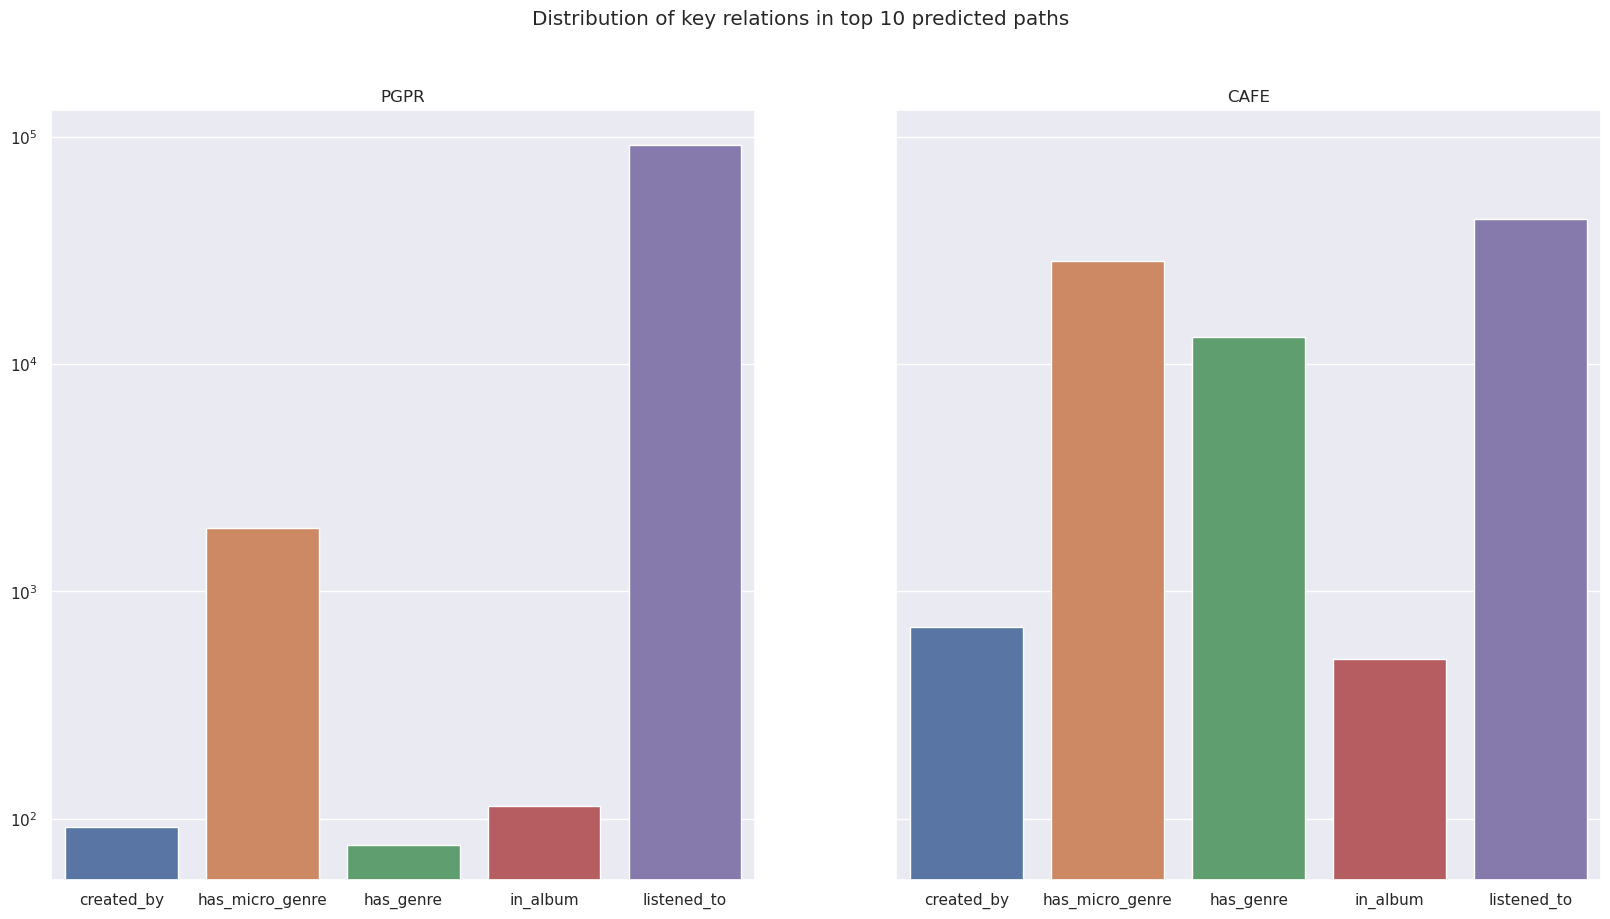

In [71]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10), sharey='row')

fig.suptitle("Distribution of key relations in top 10 predicted paths")
g = sns.barplot(ax=ax1, x=all_relations, y=[relation_counts["pgpr"][k] for k in all_relations])
g.set_yscale("log")
ax1.set_title("PGPR")

g = sns.barplot(ax=ax2, x=all_relations, y=[relation_counts["cafe"][k] for k in all_relations])
g.set_yscale("log")
ax2.set_title("CAFE")


## Divide users into age bins

A common choice of age bins is the following
0-17 (Children and adolescents)
18-34 (young adults)
35-49 (Middle aged adults)
50-64 (middle aged to adults)
65-79 (Older adults)
80+ (Elderly)

In [27]:
age_bins = [
    {
        "name": "Children and dolescents",
        "min": 0,
        "max": 17
    },
    {
        "name": "Young adults",
        "min": 18,
        "max": 34
    },
    {
        "name": "Middle aged adults",
        "min": 35,
        "max": 49
    },
    {
        "name": "Middle aged to older adults",
        "min": 50,
        "max": 64
    },
    {
        "name": "Older adults",
        "min": 65,
        "max": 79
    },
    {
        "name": "Elderly",
        "min": 80,
        "max": 100
    }
]

In [28]:
gender_bins = [
    {
        "name": "male",
        "gender": "m"
    },
    {
        "name": "female",
        "gender": "f"
    }
]

In [29]:
users = pd.read_csv('data/lfm/cleaned/users.tsv', sep='\t')
users.head()

,user_id,country,age,gender,creation_time
0,2,UK,35,m,2002-10-29 01:00:00
1,14,UK,48,m,2003-02-18 21:44:13
2,15,US,28,m,2003-02-24 03:30:33
3,36,UK,29,m,2003-03-27 12:17:12
4,42,RU,30,m,2003-04-10 01:07:48


In [30]:
user_id_mapping = pd.read_csv('data/lfm/preprocessed/users.txt', sep="\t")
user_id_mapping.head()

,new_id,raw_dataset_id
0,0,2
1,1,14
2,2,15
3,3,36
4,4,42


In [31]:
# Map the user ids to the internal ids used in the paths
users.user_id = users.user_id.apply(lambda id: user_id_mapping[user_id_mapping.raw_dataset_id == id].new_id.to_numpy()[0])

In [32]:
users.head()

,user_id,country,age,gender,creation_time
0,0,UK,35,m,2002-10-29 01:00:00
1,1,UK,48,m,2003-02-18 21:44:13
2,2,US,28,m,2003-02-24 03:30:33
3,3,UK,29,m,2003-03-27 12:17:12
4,4,RU,30,m,2003-04-10 01:07:48


In [33]:
for age_bin in age_bins:
    age_bin["user_ids"] = users[(users.age >= age_bin["min"]) & (users.age <= age_bin["max"])].user_id.to_numpy()
    age_bin["total_count"] = len(age_bin["user_ids"])
    age_bin["total_train_item_count"] = 0
    age_bin["total_test_item_count"] = 0
    for user in age_bin["user_ids"]:
        age_bin["total_train_item_count"] = age_bin["total_train_item_count"] + len(train_labels[pgpr][user])
        age_bin["total_test_item_count"] = age_bin["total_test_item_count"] + len(test_labels[pgpr][user])

In [34]:
for gender_bin in gender_bins:
    gender_bin["user_ids"] = users[users.gender == gender_bin["gender"]].user_id.to_numpy()
    gender_bin["total_count"] = len(gender_bin["user_ids"])
    gender_bin["total_train_item_count"] = 0
    gender_bin["total_test_item_count"] = 0
    for user in gender_bin["user_ids"]:
        gender_bin["total_train_item_count"] = gender_bin["total_train_item_count"] + len(train_labels[pgpr][user])
        gender_bin["total_test_item_count"] = gender_bin["total_test_item_count"] + len(test_labels[pgpr][user])

In [35]:
gender_bins

[{'name': 'male',
  'gender': 'm',
  'user_ids': array([   0,    1,    2, ..., 9449, 9451, 9452]),
  'total_count': 7679,
  'total_train_item_count': 3307565,
  'total_test_item_count': 830761},
 {'name': 'female',
  'gender': 'f',
  'user_ids': array([   5,    7,   20, ..., 9450, 9453, 9454]),
  'total_count': 1776,
  'total_train_item_count': 633954,
  'total_test_item_count': 159346}]

<Axes: >

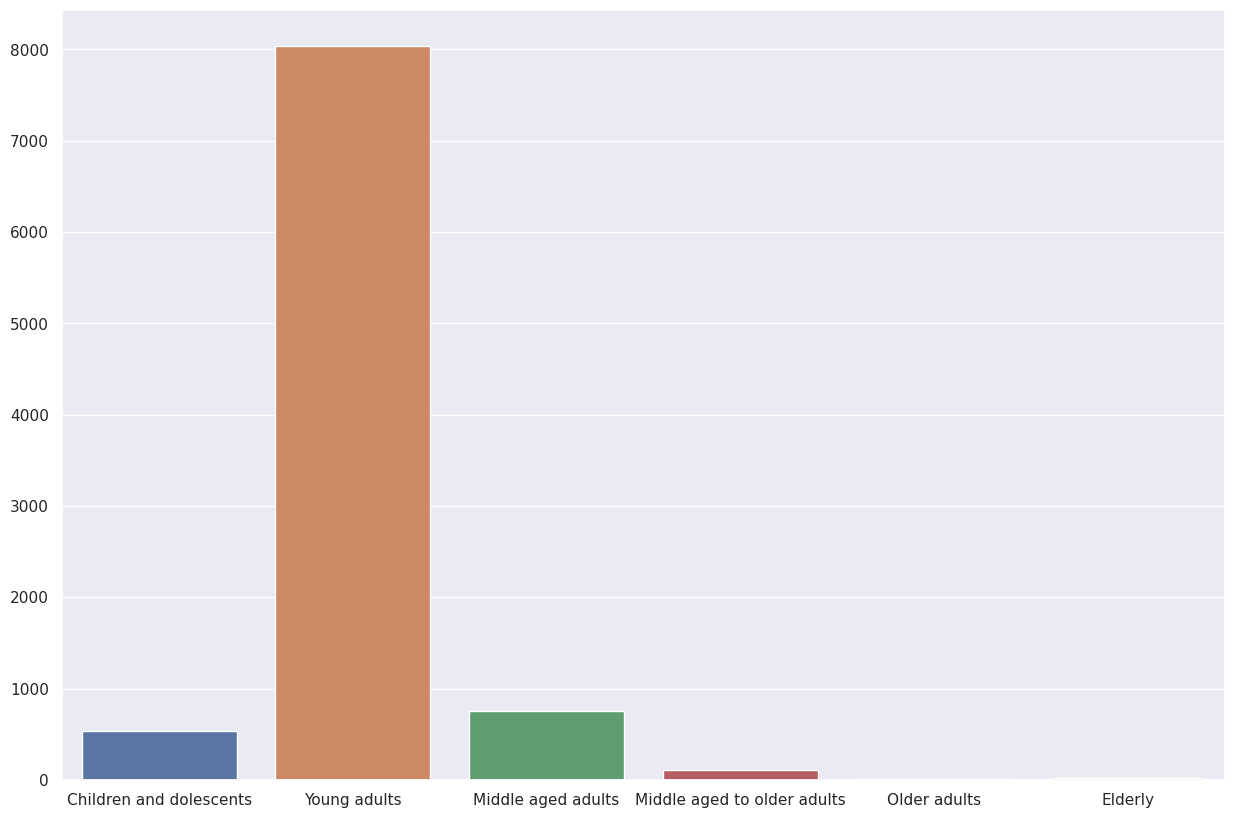

In [36]:
plt.figure(figsize=(15,10))
sns.barplot(x=[age_bin["name"] for age_bin in age_bins], y=[age_bin["total_count"] for age_bin in age_bins])

<Axes: >

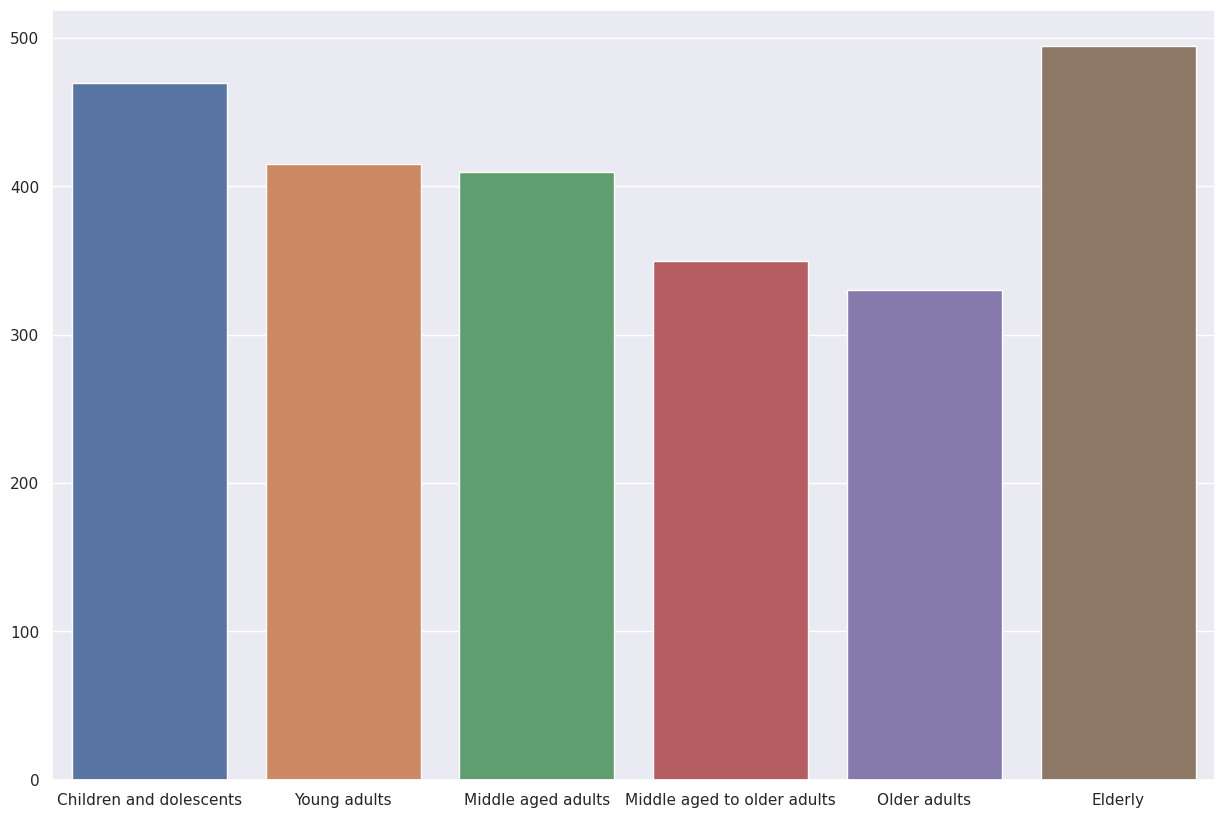

In [40]:
plt.figure(figsize=(15,10))
sns.barplot(x=[age_bin["name"] for age_bin in age_bins], y=[age_bin["total_train_item_count"]/age_bin["total_count"] for age_bin in age_bins])

<Axes: >

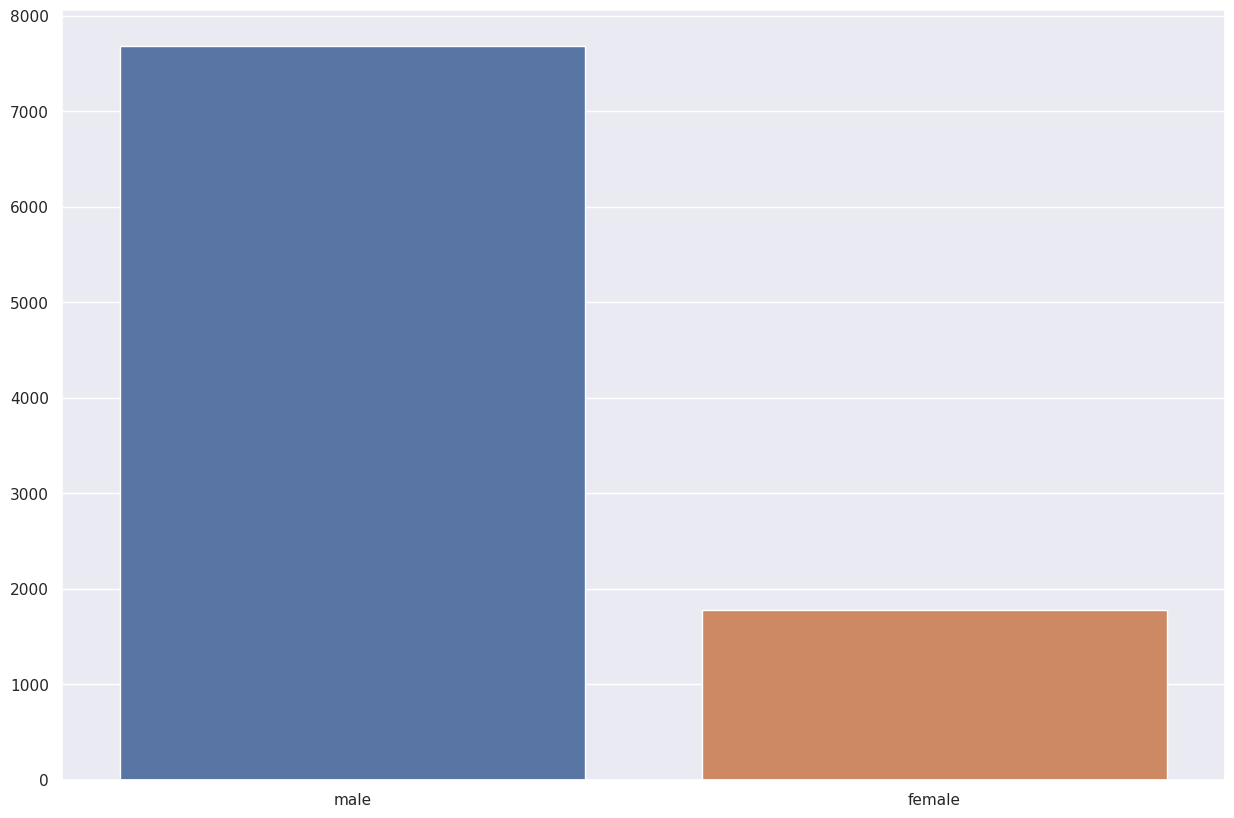

In [37]:
plt.figure(figsize=(15,10))
sns.barplot(x=[gender_bin["name"] for gender_bin in gender_bins], y=[gender_bin["total_count"] for gender_bin in gender_bins])

<Axes: >

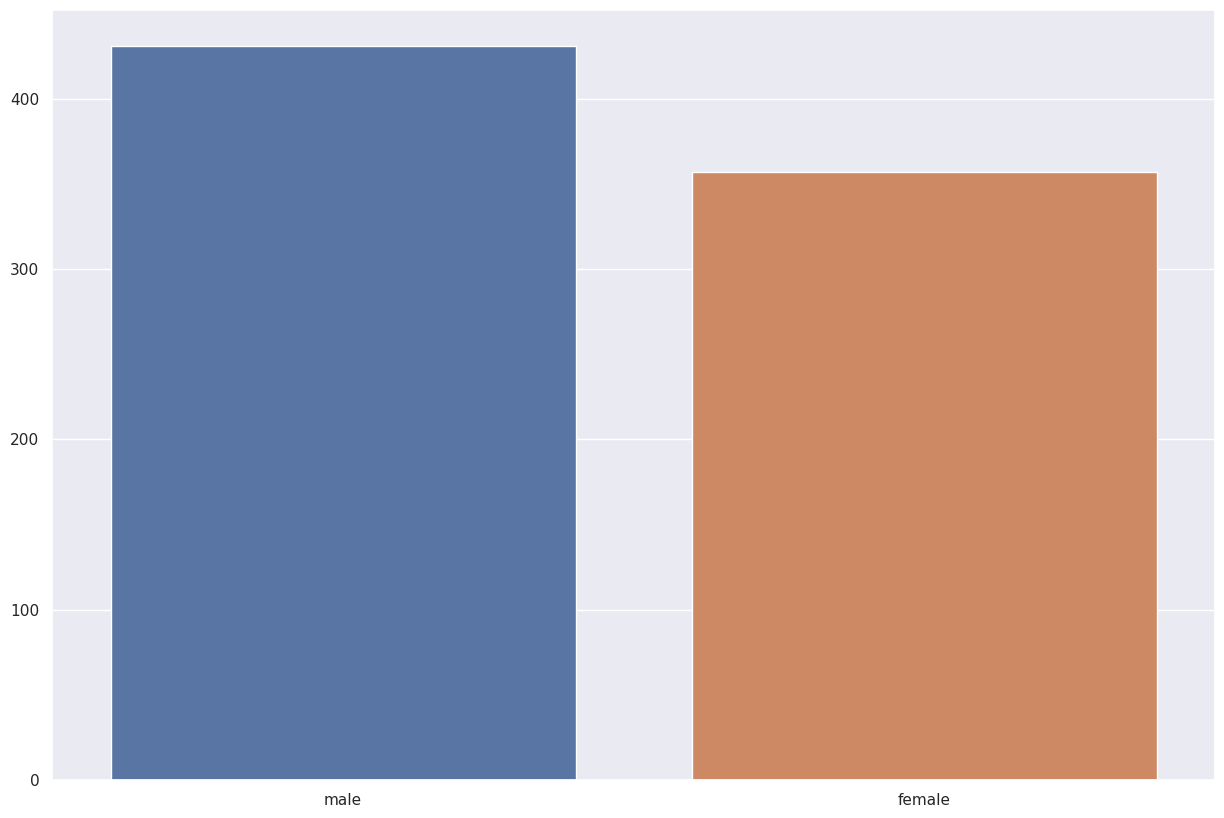

In [41]:
plt.figure(figsize=(15,10))
sns.barplot(x=[gender_bin["name"] for gender_bin in gender_bins], y=[gender_bin["total_train_item_count"]/gender_bin["total_count"] for gender_bin in gender_bins])

In [38]:
topk_paths[model_name]

### Calculate metrics for age bins

In [52]:
age_metrics = {}
for model in models:
    age_metrics[model] = {}
    print("Evaluating ", model)
    for age_bin in age_bins:
        print("Age bin:", age_bin["name"])
        bin_paths = {k: topk_paths[model][k] for k in age_bin["user_ids"]}
        metrics_for_top_k(bin_paths, model)
        age_metrics[model][age_bin["name"]] = {}
        age_metrics[model][age_bin["name"]]["relation_counts"] = count_relations(user_topk=bin_paths, model=model, relative=True)
        ndcg, precision, recall = metrics_for_top_k(user_topk=bin_paths, model=model)
        age_metrics[model][age_bin["name"]]["ndcg"] = ndcg
        age_metrics[model][age_bin["name"]]["precision"] = precision
        age_metrics[model][age_bin["name"]]["recall"] = recall

age_metrics

Evaluating  cafe
Age bin: Children and dolescents
Overall NDGC: 0.10677986922448081, Precision: 0.028436911487758943, Recall: 0.0028350931468206987
Overall NDGC: 0.10677986922448081, Precision: 0.028436911487758943, Recall: 0.0028350931468206987
Age bin: Young adults
Overall NDGC: 0.07546729209164947, Precision: 0.01944479024025893, Recall: 0.0030351568342967625
Overall NDGC: 0.07546729209164947, Precision: 0.01944479024025893, Recall: 0.0030351568342967625
Age bin: Middle aged adults
Overall NDGC: 0.06884776827880326, Precision: 0.01673254281949934, Recall: 0.003422856752897002
Overall NDGC: 0.06884776827880326, Precision: 0.01673254281949934, Recall: 0.003422856752897002
Age bin: Middle aged to older adults
Overall NDGC: 0.036406440921157, Precision: 0.011111111111111113, Recall: 0.0021707065263029315
Overall NDGC: 0.036406440921157, Precision: 0.011111111111111113, Recall: 0.0021707065263029315
Age bin: Older adults
Overall NDGC: 0.14285714285714285, Precision: 0.014285714285714287,

{'cafe': {'Children and dolescents': {'relation_counts': {'listened_to': 49.21402660217654,
    'has_genre': 16.16283756549778,
    'has_micro_genre': 33.77670294236195,
    'created_by': 0.6247480854494155,
    'in_album': 0.22168480451430875},
   'ndcg': 0.10677986922448081,
   'precision': 0.028436911487758943,
   'recall': 0.0028350931468206987},
  'Young adults': {'relation_counts': {'listened_to': 50.471846277808886,
    'has_micro_genre': 32.966417655654645,
    'has_genre': 15.15780560752769,
    'created_by': 0.8207803558991027,
    'in_album': 0.5831501031096786},
   'ndcg': 0.07546729209164947,
   'precision': 0.01944479024025893,
   'recall': 0.0030351568342967625},
  'Middle aged adults': {'relation_counts': {'listened_to': 50.46836719988471,
    'has_genre': 15.56420233463035,
    'has_micro_genre': 32.396598933563915,
    'created_by': 0.879089205937455,
    'in_album': 0.6917423259835711},
   'ndcg': 0.06884776827880326,
   'precision': 0.01673254281949934,
   'recall':

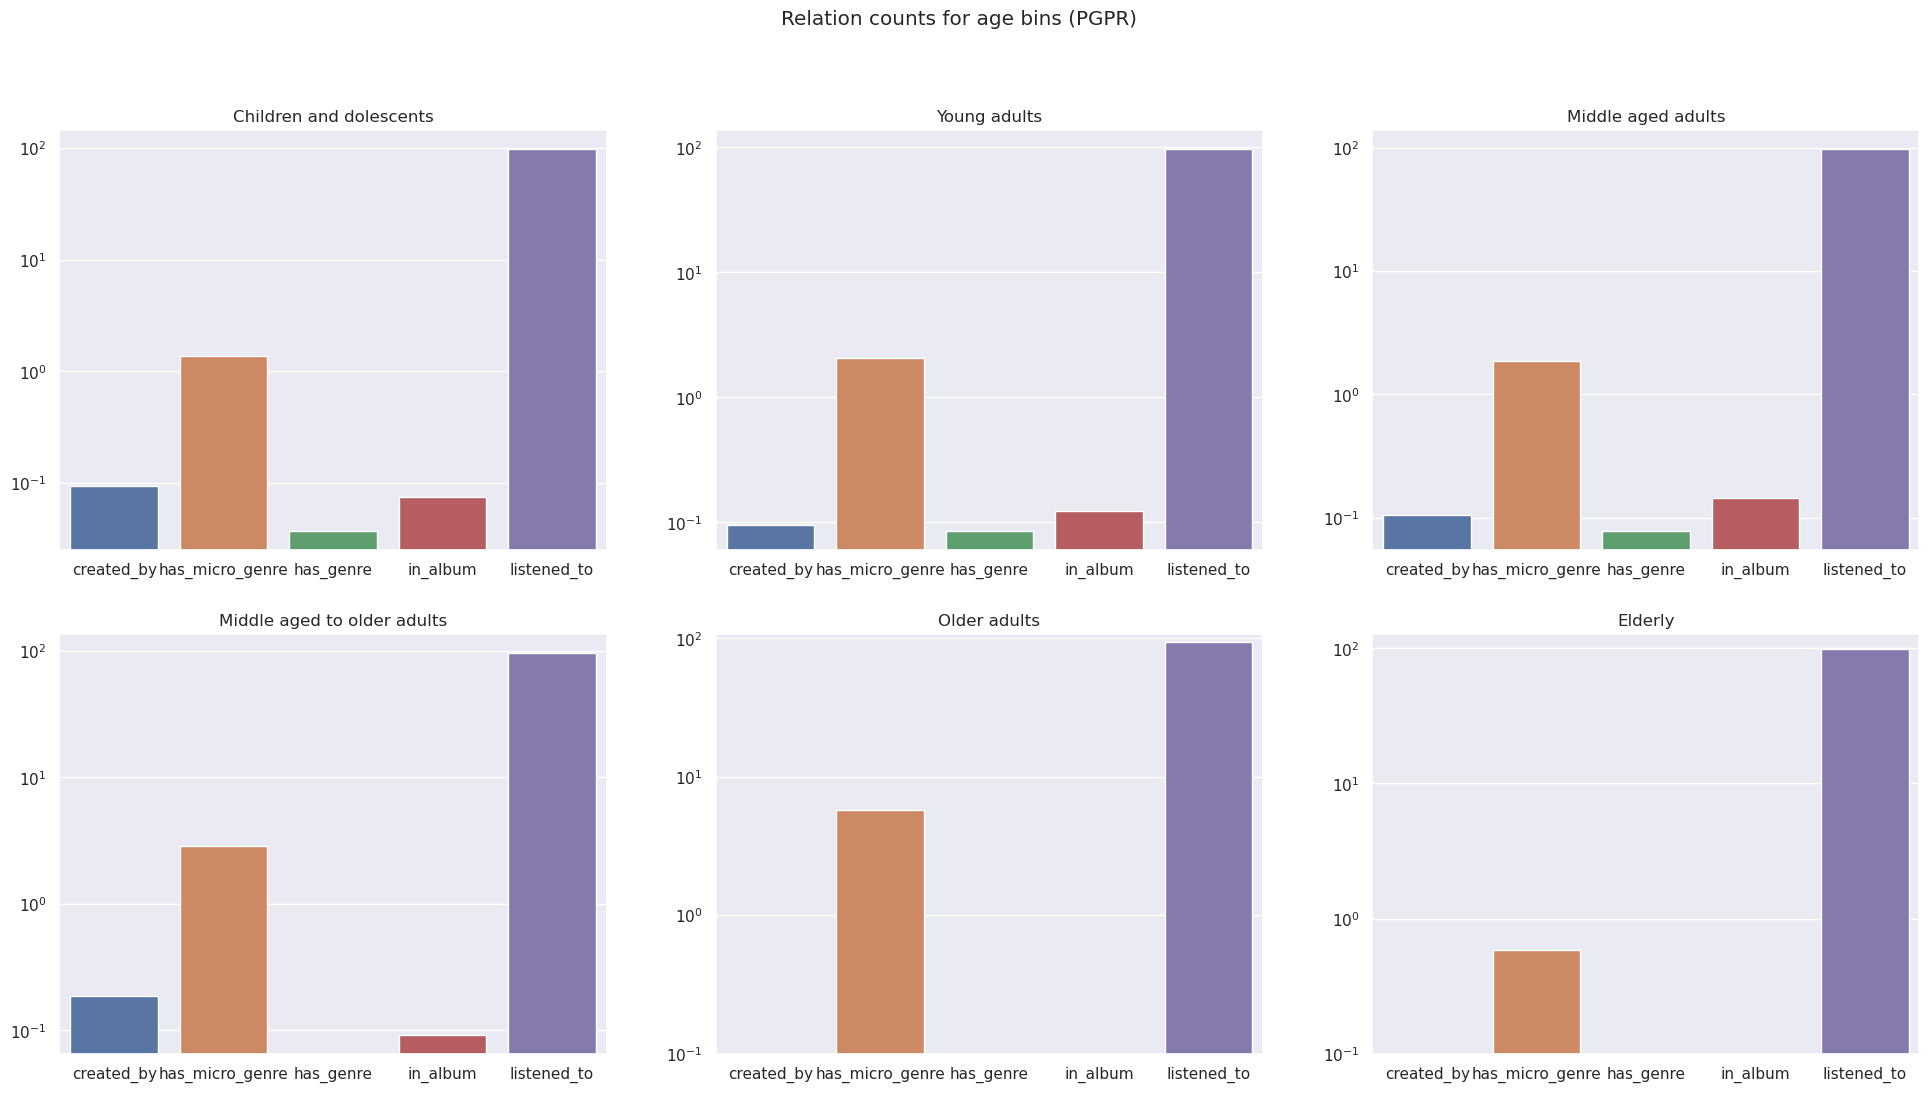

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
fig.suptitle("Relation counts for age bins (PGPR)")
model_name = pgpr
for age_bin_name, ax in zip(age_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[age_metrics[model_name][age_bin_name]["relation_counts"][k] if k in age_metrics[model_name][age_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(age_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


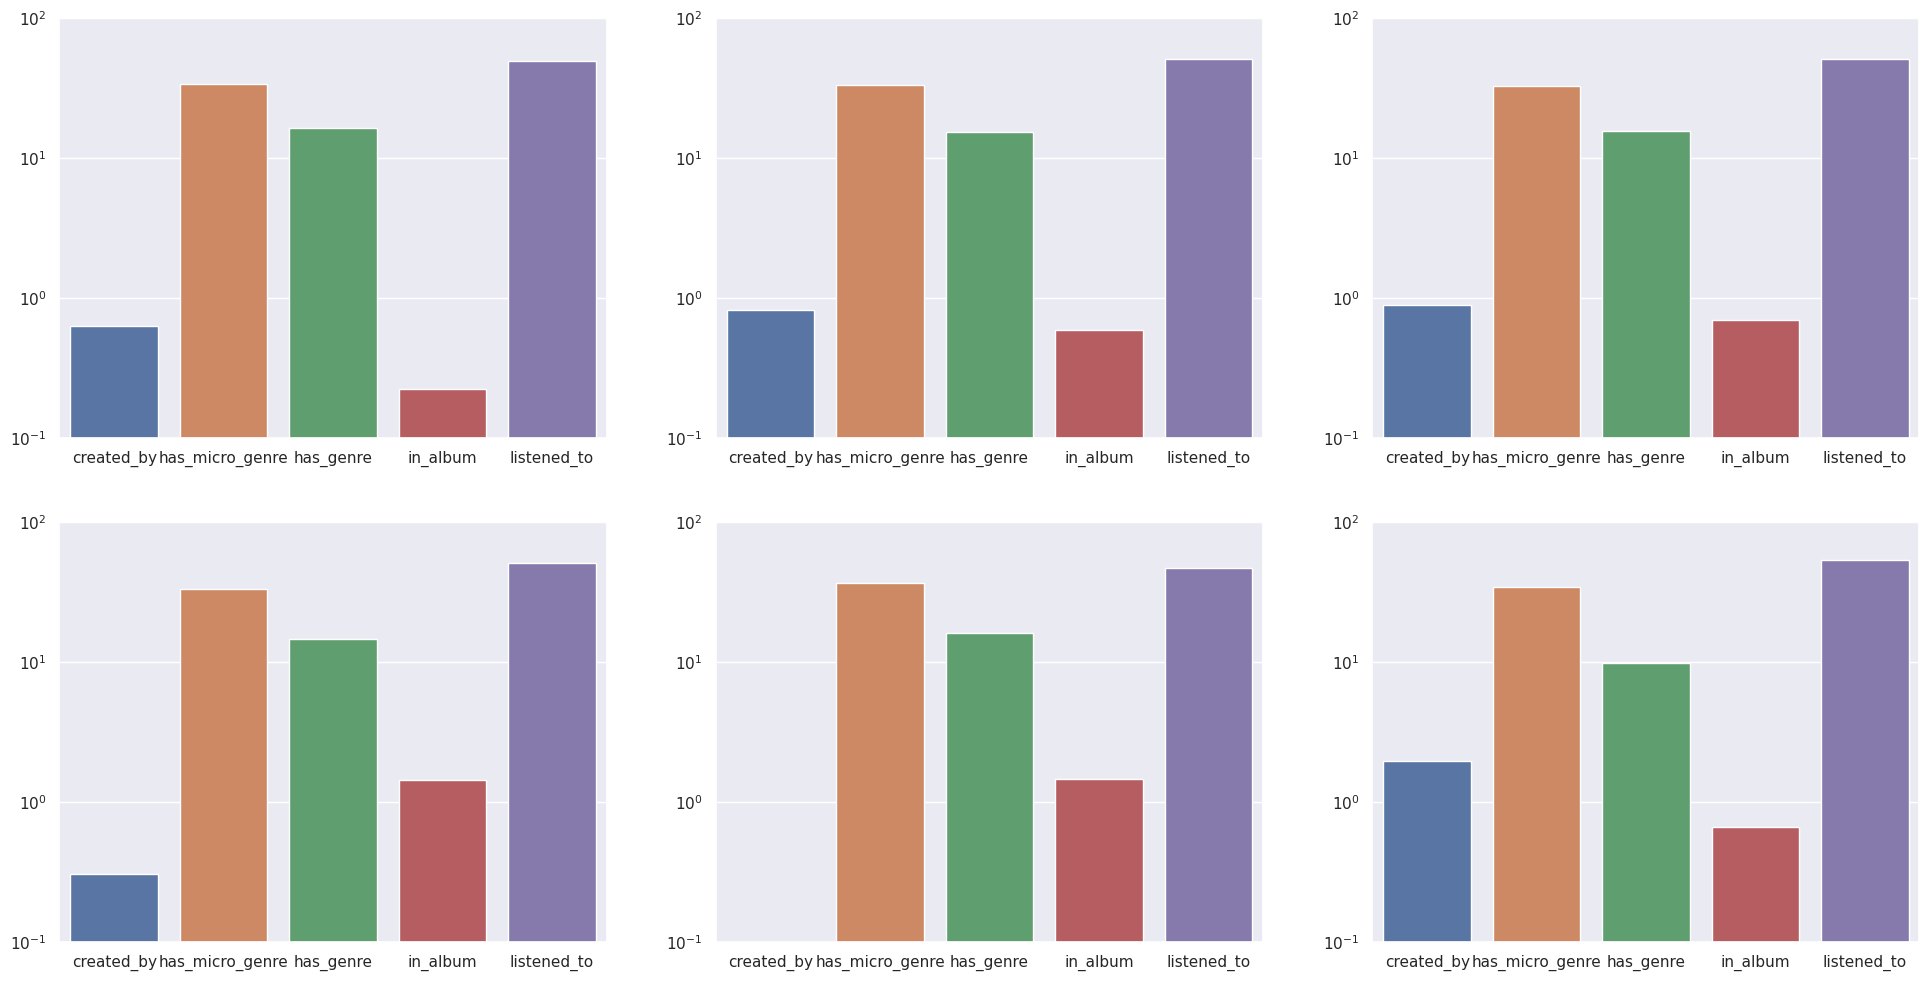

In [74]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
fig.suptitle("Relation counts for age bins (CAFE)")
all_relations = ["created_by", "has_micro_genre", "has_genre", "in_album", "listened_to"]
model_name = cafe
for age_bin_name, ax in zip(age_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[age_metrics[model_name][age_bin_name]["relation_counts"][k] if k in age_metrics[model_name][age_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(age_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


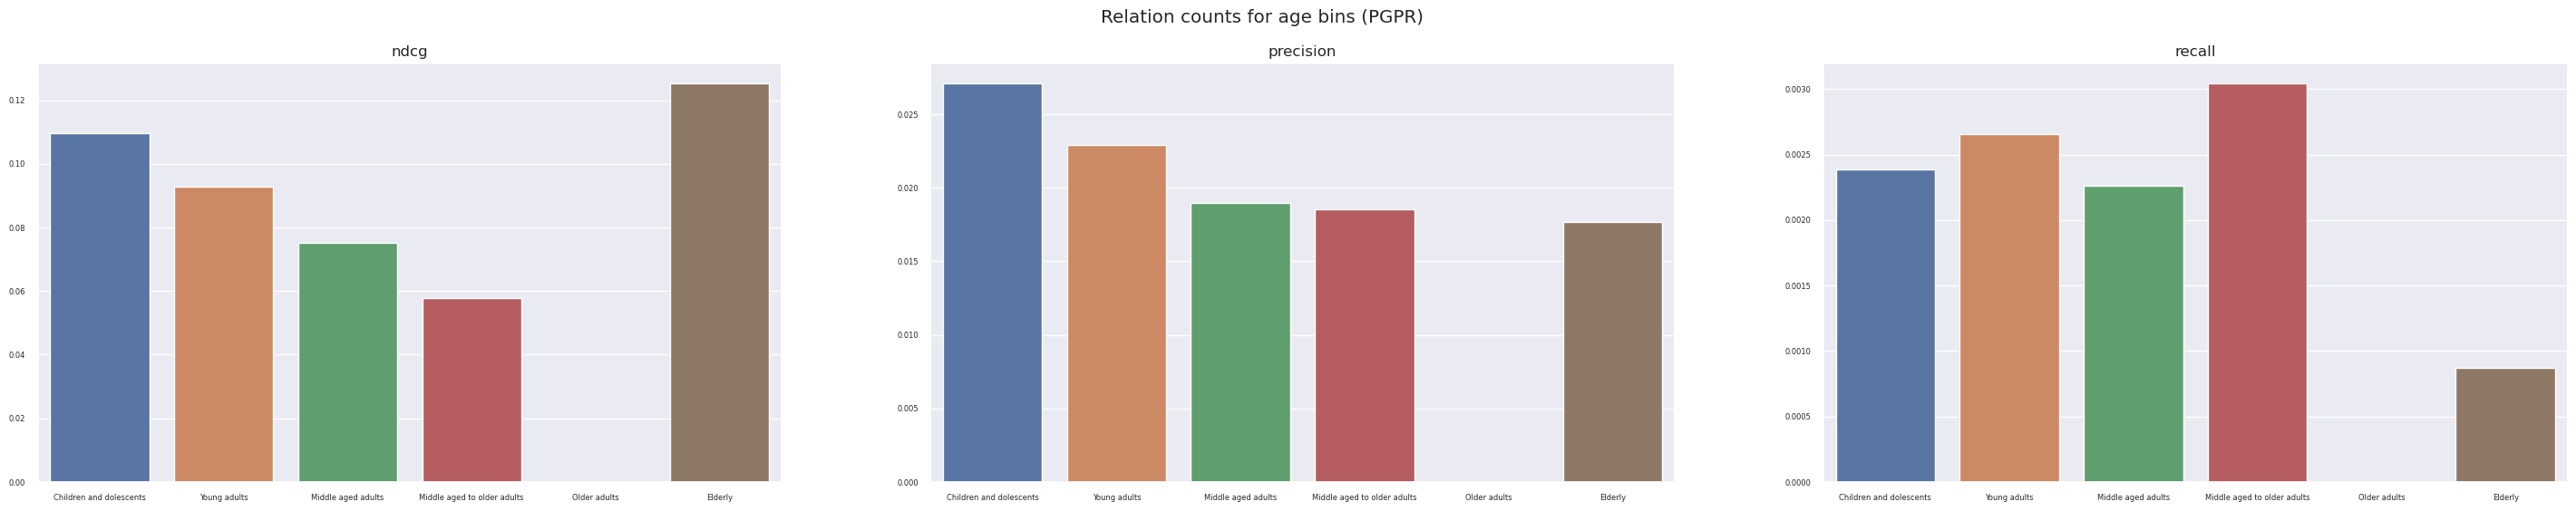

In [100]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Relation counts for age bins (PGPR)")
model_name = pgpr
for metric_name, ax in zip(["ndcg", "precision", "recall"], axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[age_bin["name"] for age_bin in age_bins], y=[age_metrics[model_name][age_bin["name"]][metric_name] for age_bin in age_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)


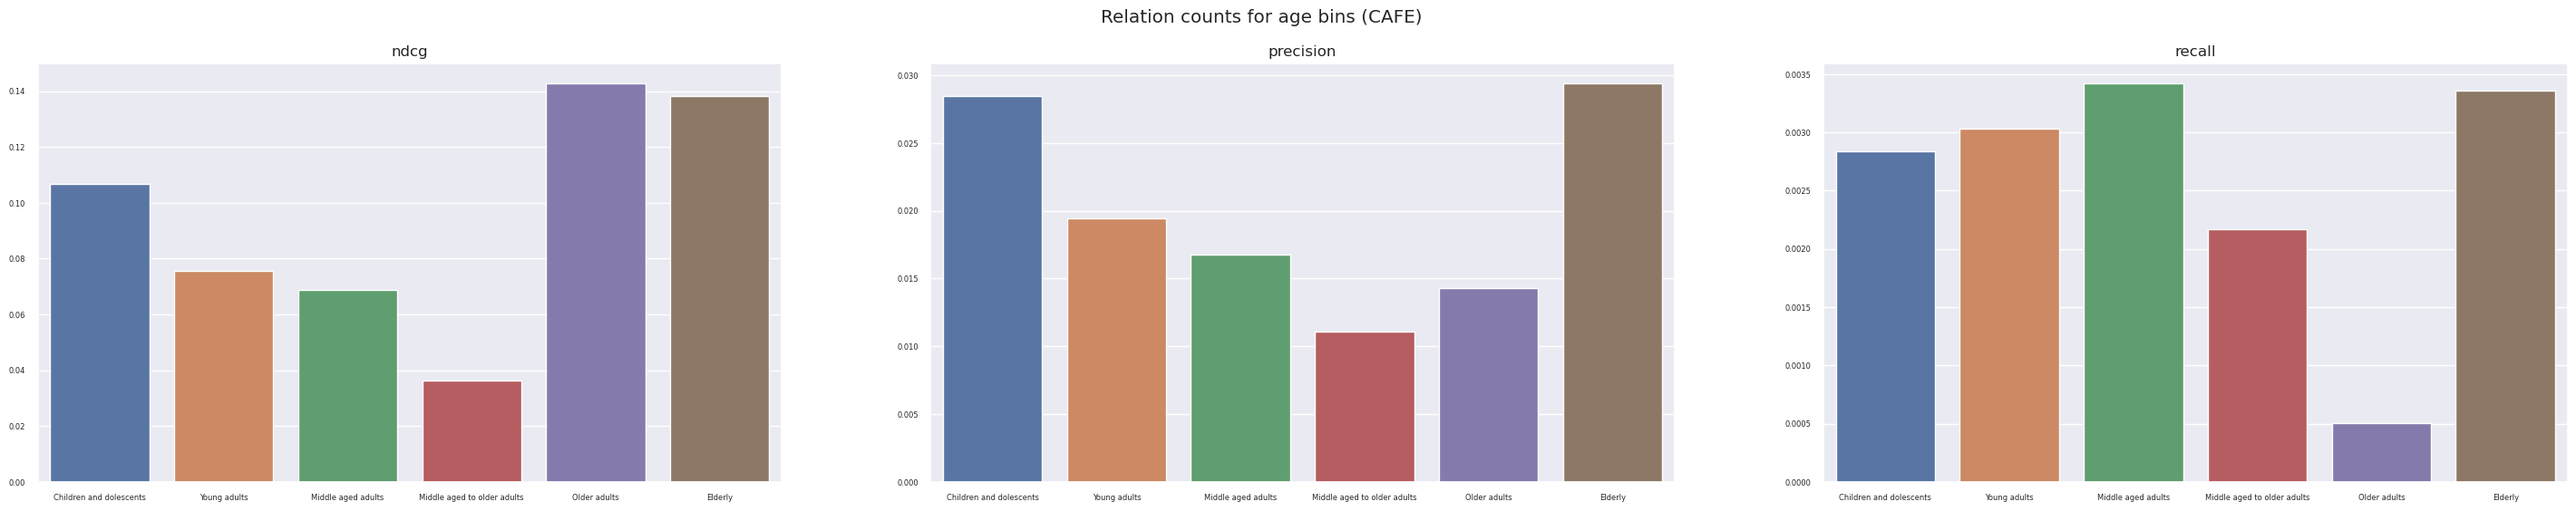

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Relation counts for age bins (CAFE)")
model_name = cafe
for metric_name, ax in zip(["ndcg", "precision", "recall"], axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[age_bin["name"] for age_bin in age_bins], y=[age_metrics[model_name][age_bin["name"]][metric_name] for age_bin in age_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)


### Calculate metrics for gender bins

In [79]:
gender_metrics = {}
for model in models:
    gender_metrics[model] = {}
    print("Evaluating ", model)
    for gender_bin in gender_bins:
        print("Age bin:", gender_bin["name"])
        bin_paths = {k: topk_paths[model][k] for k in gender_bin["user_ids"]}
        metrics_for_top_k(bin_paths, model)
        gender_metrics[model][gender_bin["name"]] = {}
        gender_metrics[model][gender_bin["name"]]["relation_counts"] = count_relations(user_topk=bin_paths, model=model, relative=True)
        ndcg, precision, recall = metrics_for_top_k(user_topk=bin_paths, model=model)
        gender_metrics[model][gender_bin["name"]]["ndcg"] = ndcg
        gender_metrics[model][gender_bin["name"]]["precision"] = precision
        gender_metrics[model][gender_bin["name"]]["recall"] = recall

gender_metrics

Evaluating  cafe
Age bin: male
Overall NDGC: 0.07865742329254233, Precision: 0.0204714155488996, Recall: 0.0030509429452568273
Overall NDGC: 0.07865742329254233, Precision: 0.0204714155488996, Recall: 0.0030509429452568273
Age bin: female
Overall NDGC: 0.06669711015555783, Precision: 0.016103603603603602, Recall: 0.003013325622457999
Overall NDGC: 0.06669711015555783, Precision: 0.016103603603603602, Recall: 0.003013325622457999
Evaluating  pgpr
Age bin: male
Overall NDGC: 0.09287563284495853, Precision: 0.022841515822372704, Recall: 0.0024870298672527427
Overall NDGC: 0.09287563284495853, Precision: 0.022841515822372704, Recall: 0.0024870298672527427
Age bin: female
Overall NDGC: 0.0883222063364806, Precision: 0.022466216216216216, Recall: 0.003128551561547351
Overall NDGC: 0.0883222063364806, Precision: 0.022466216216216216, Recall: 0.003128551561547351


{'cafe': {'male': {'relation_counts': {'listened_to': 50.59260847808993,
    'has_genre': 15.020373150332404,
    'has_micro_genre': 32.97019086425048,
    'created_by': 0.8392308242190293,
    'in_album': 0.5775966831081564},
   'ndcg': 0.07865742329254233,
   'precision': 0.0204714155488996,
   'recall': 0.0030509429452568273},
  'female': {'relation_counts': {'listened_to': 49.60336831828167,
    'has_genre': 16.127654381254576,
    'has_micro_genre': 32.98755186721991,
    'created_by': 0.6834268977300464,
    'in_album': 0.5979985355137906},
   'ndcg': 0.06669711015555783,
   'precision': 0.016103603603603602,
   'recall': 0.003013325622457999}},
 'pgpr': {'male': {'relation_counts': {'listened_to': 97.62338846203933,
    'has_micro_genre': 2.053652819377523,
    'has_genre': 0.0872509441333507,
    'created_by': 0.10808699049355384,
    'in_album': 0.1276207839562443},
   'ndcg': 0.09287563284495853,
   'precision': 0.022841515822372704,
   'recall': 0.0024870298672527427},
  'fe

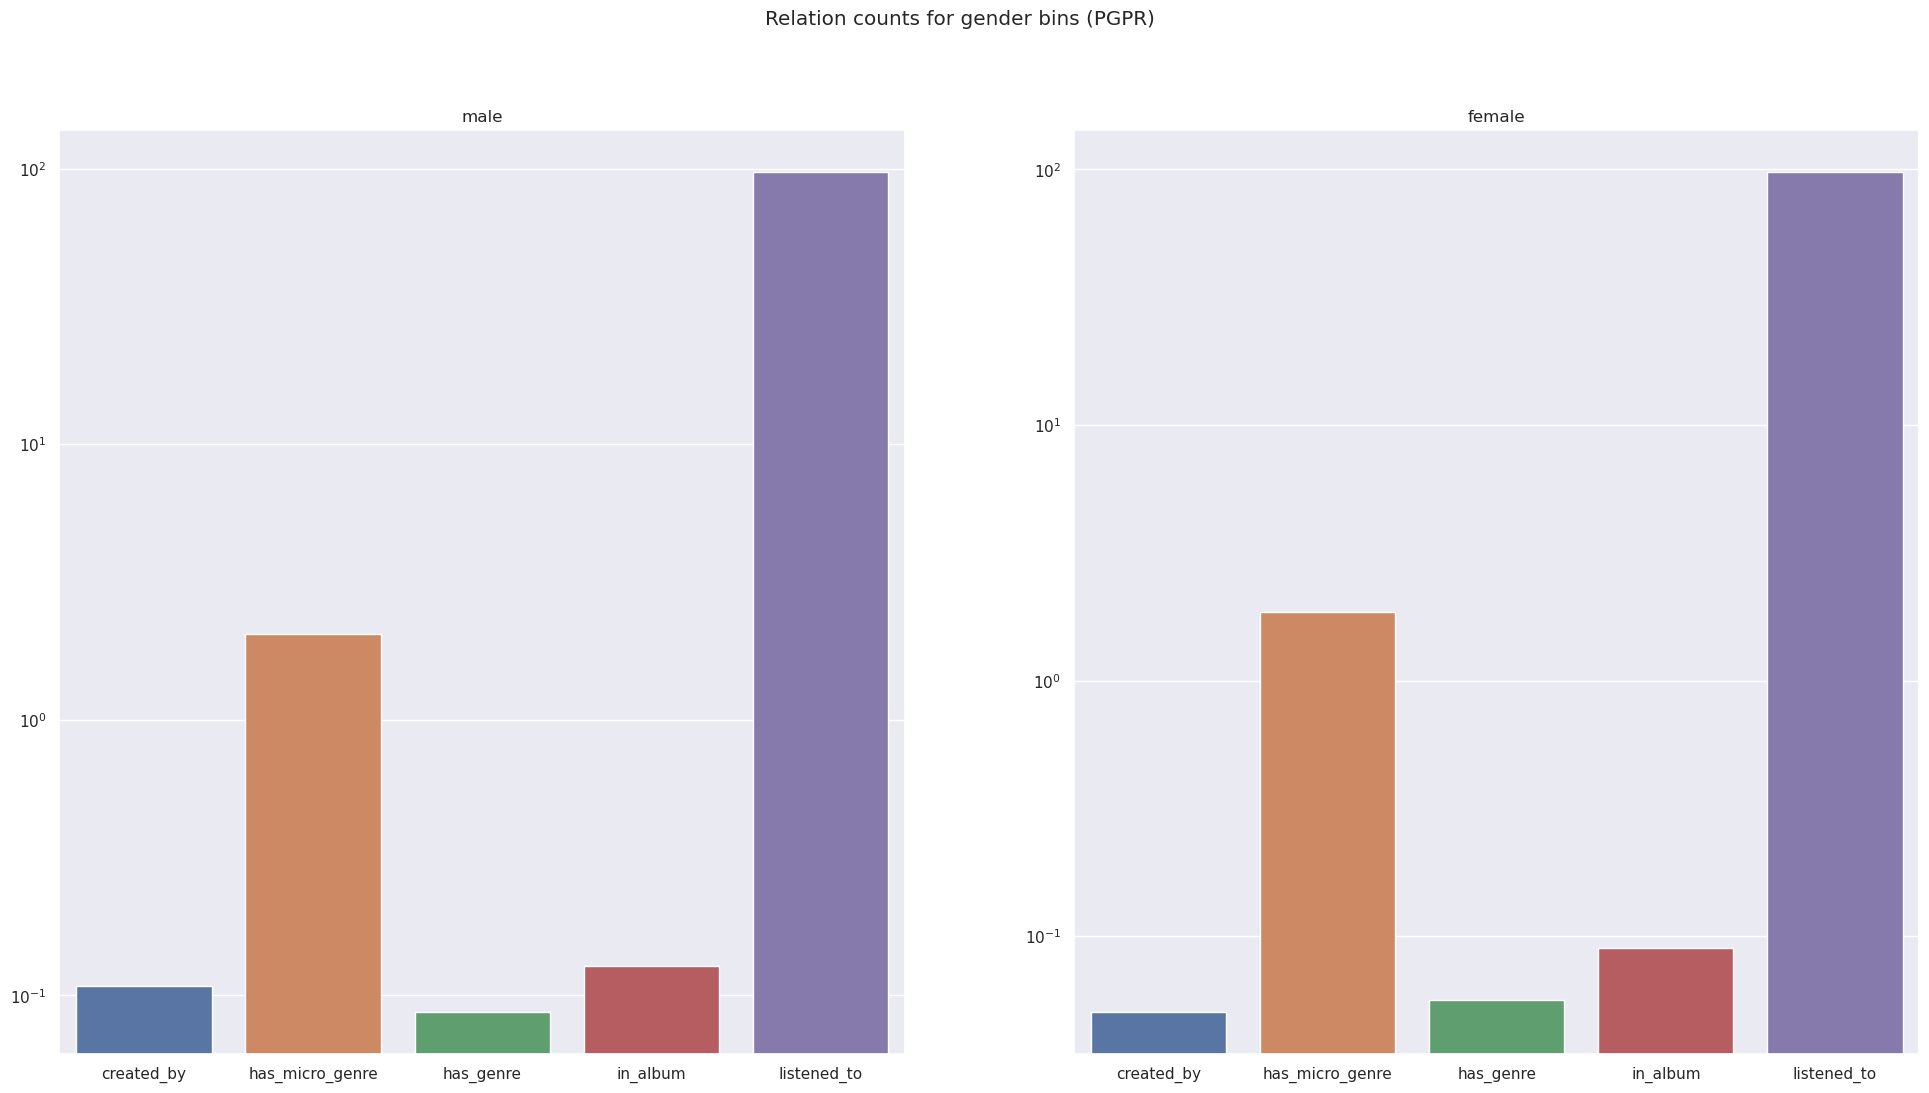

In [84]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
fig.suptitle("Relation counts for gender bins (PGPR)")
all_relations = ["created_by", "has_micro_genre", "has_genre", "in_album", "listened_to"]
model_name = pgpr
for gender_bin_name, ax in zip(gender_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[gender_metrics[model_name][gender_bin_name]["relation_counts"][k] if k in gender_metrics[model_name][gender_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(gender_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


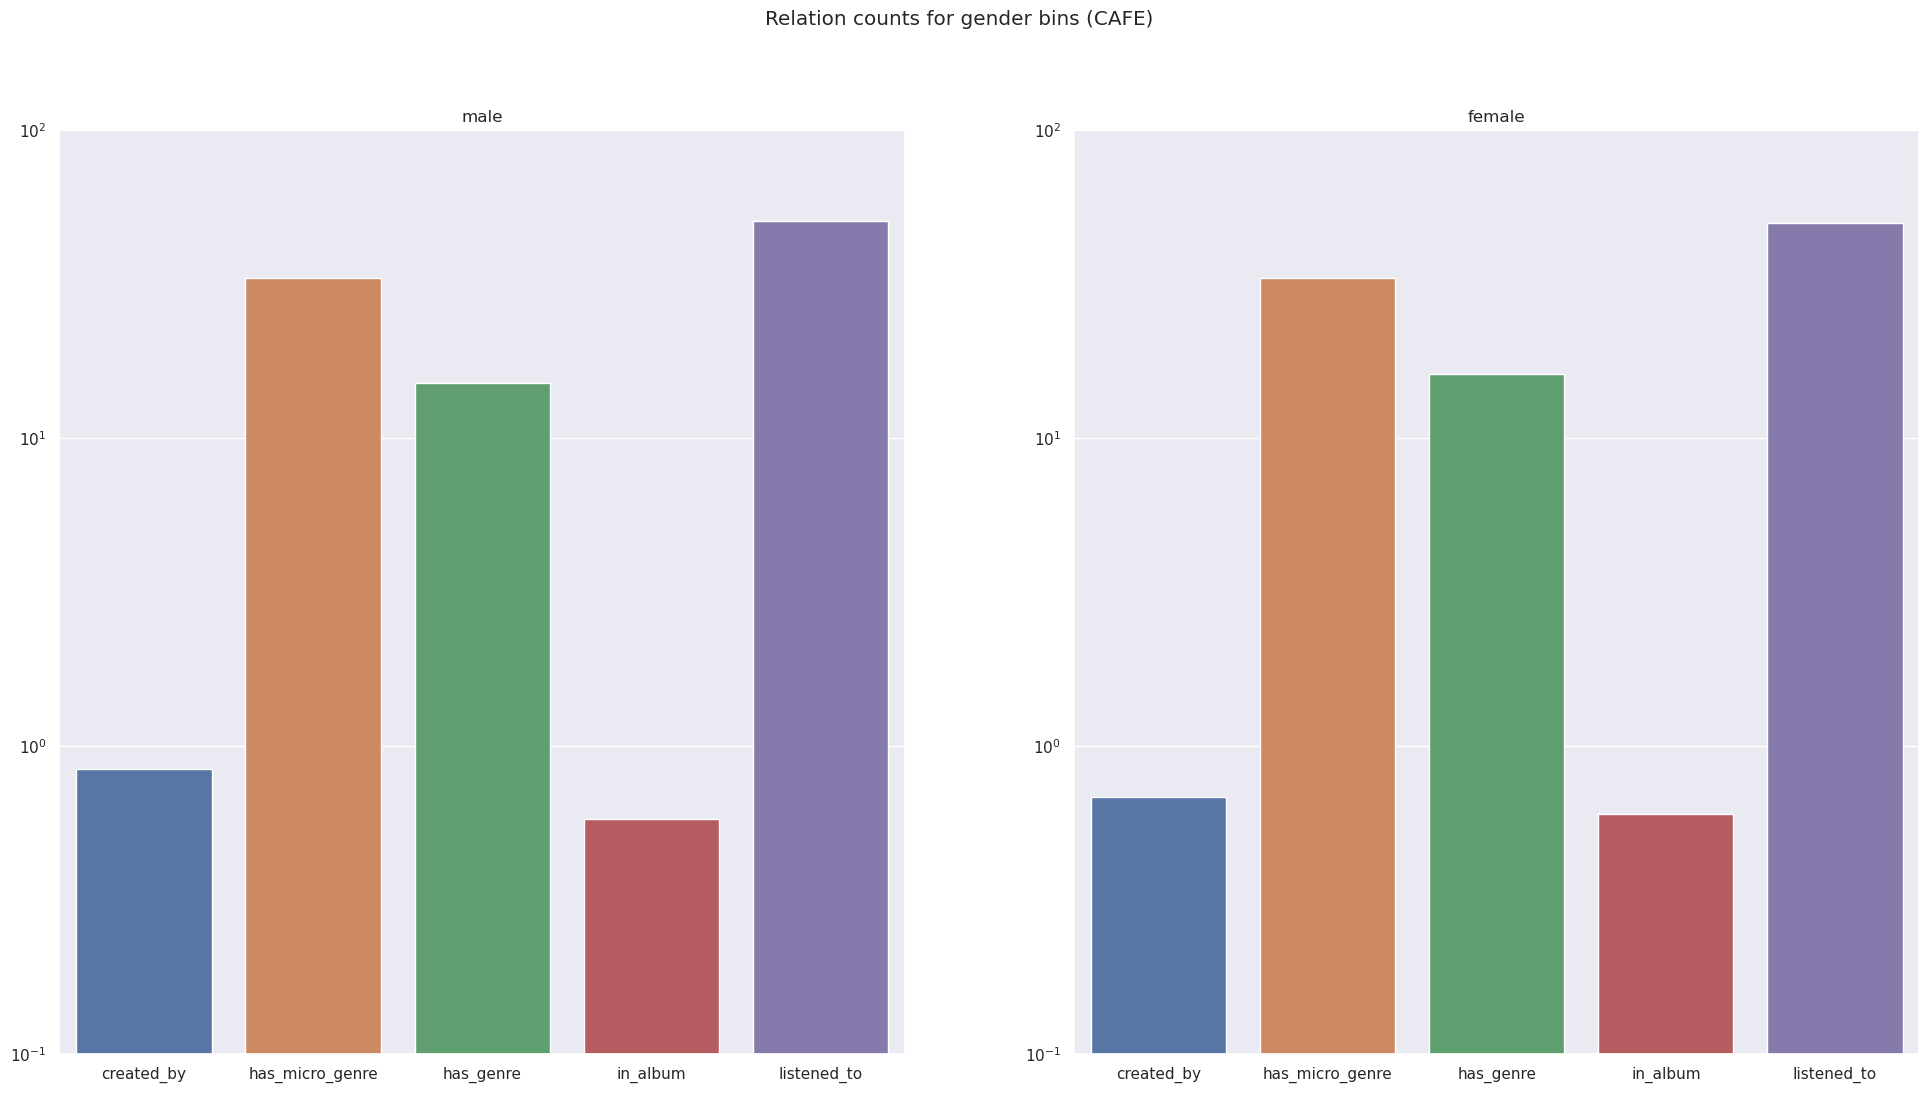

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
fig.suptitle("Relation counts for gender bins (CAFE)")
all_relations = ["created_by", "has_micro_genre", "has_genre", "in_album", "listened_to"]
model_name = cafe
for gender_bin_name, ax in zip(gender_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[gender_metrics[model_name][gender_bin_name]["relation_counts"][k] if k in gender_metrics[model_name][gender_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(gender_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


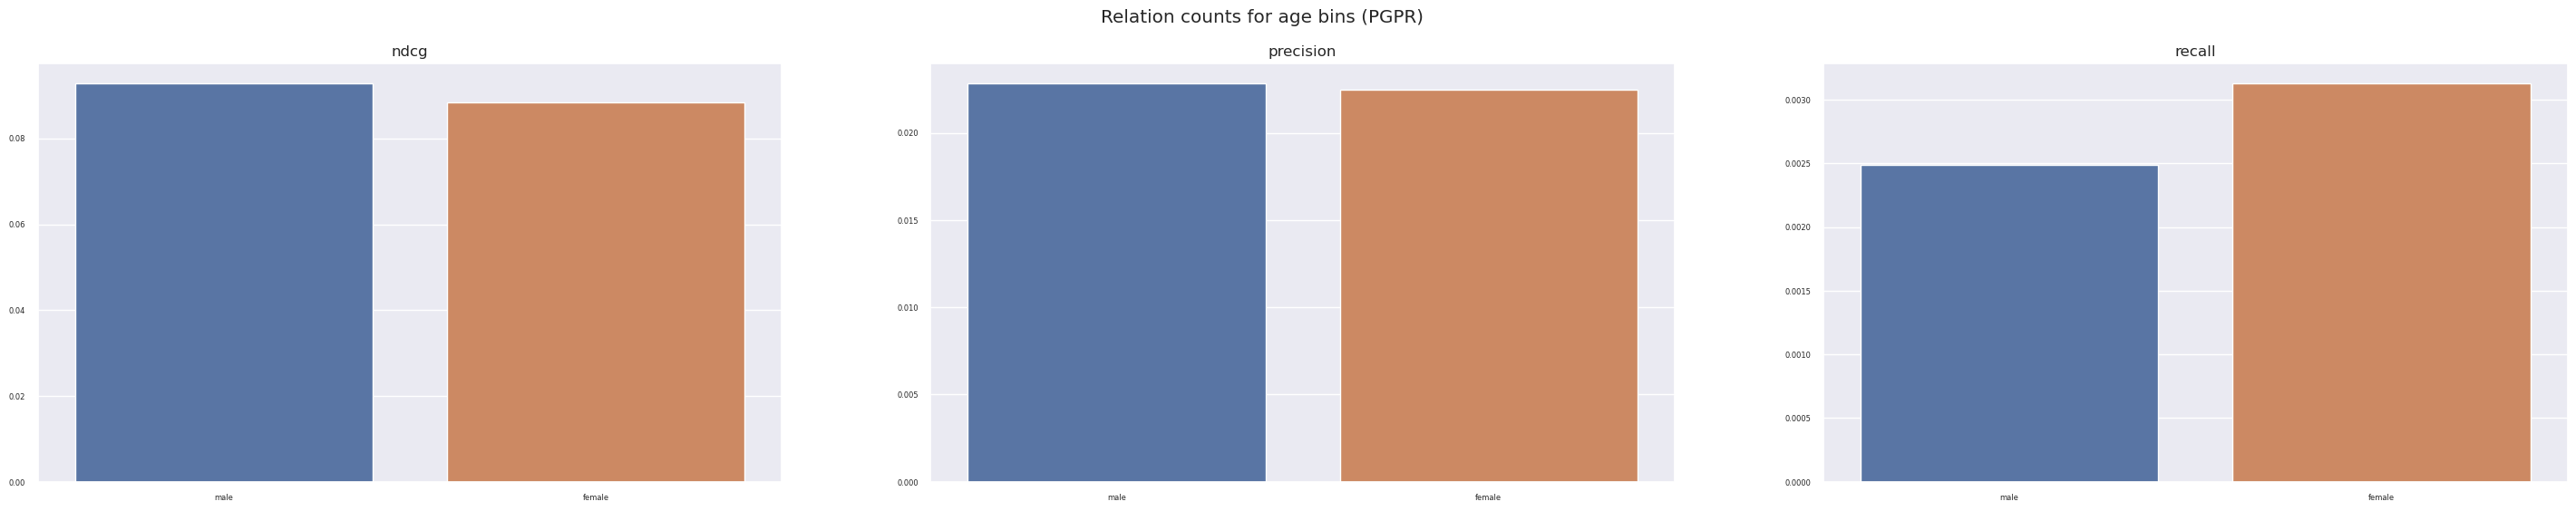

In [102]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Relation counts for age bins (PGPR)")
model_name = pgpr
for metric_name, ax in zip(["ndcg", "precision", "recall"], axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[gender_bin["name"] for gender_bin in gender_bins], y=[gender_metrics[model_name][gender_bin["name"]][metric_name] for gender_bin in gender_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)


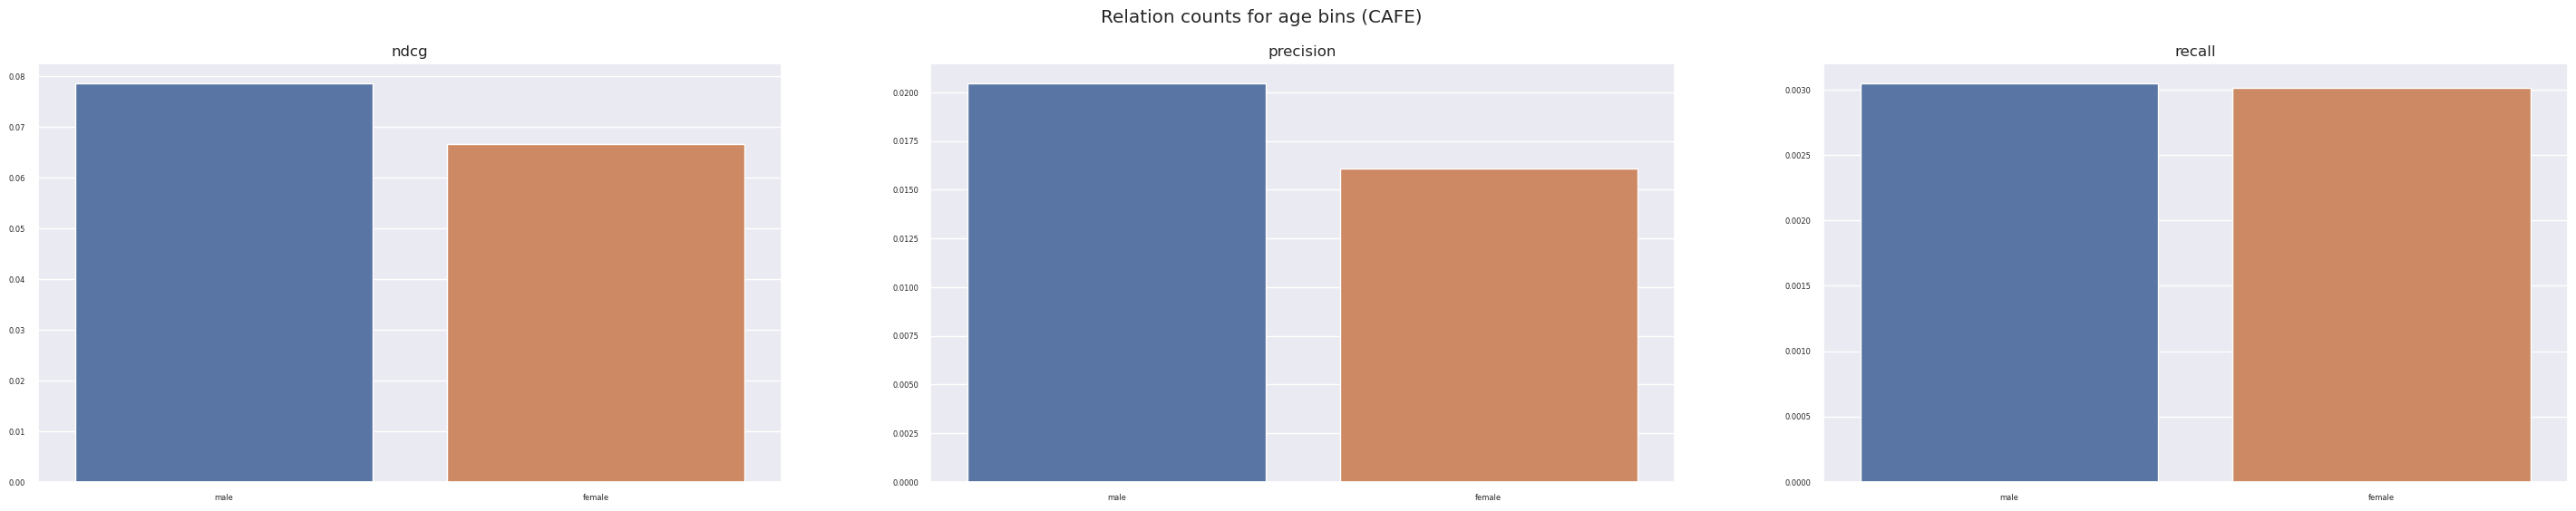

In [104]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Relation counts for age bins (CAFE)")
model_name = cafe
for metric_name, ax in zip(["ndcg", "precision", "recall"], axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[gender_bin["name"] for gender_bin in gender_bins], y=[gender_metrics[model_name][gender_bin["name"]][metric_name] for gender_bin in gender_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)
